# Example on how to use E-NAUTILUS with a pre-computed Pareto front
We begin by importing the necessary libraries.

In [2]:
import logging

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler  # for scaling the data
import ipywidgets as widgets

from desdeo.problem.Problem import ScalarMOProblem
from desdeo.methods.Nautilus import ENautilus

logging.getLogger("matplotlib").setLevel(logging.WARNING)

For later use, define a function to display the objective functions as grouped bar charts and a function to create a widget to select intermediate points. These function are used for pure visualization, they are not related to the E-Nautilus procedure.

In [3]:
def display_options(zs, lows=None, names=None):
    if np.ndim(zs) == 1:
        n_rows = 1
        n_cols = len(zs)
        zs = np.array([list(zs)])
    else:
        n_rows, n_cols = zs.shape

    bar_width = 1 / (n_cols + 1)

    bars = zs.T
    xs = np.zeros((n_cols, n_rows))
    xs[0] = np.arange(n_rows)
    
    for i in range(1, n_cols):
        xs[i] = xs[i-1] + bar_width

    for j in range(n_cols):
        plt.bar(xs[j], bars[j], width=bar_width, label='obj_{}'.format(j))
        if lows is not None:
            plt.bar(xs[j], lows.T[j], color="black", width=bar_width)

    plt.legend()
    plt.xlabel("Options", fontweight='bold')
    if names is None:
        names =  [i+1 for i in range(n_rows)]
    plt.xticks([(r + bar_width) + (0.5*(n_cols)*bar_width)/2 for r in range(n_rows)], names)
    
def z_selector(zs):
    res = widgets.Dropdown(
    options=[i for i in range(1, len(zs)+1)]
    )
    return res

## Loading and scaling the data
Next we need to load the representation of the Pareto front into two arrays. One containing the solutions and the other containing the corresponding objective vectors.  Normalize the data between 0 and 1 column wise. This normalization is done because the magnitudes of the different objective function may vary a lot. Visualizing these objectives would be problematic otherwise. This will still give a good idea of the fit of each objective, with 0 being the worst possible value and 1 being the best.

In [4]:
decision_variables_file = "./data/decision_result.csv"
objective_vectors_file = "./data/objective_result.csv"
xs = np.genfromtxt(decision_variables_file, delimiter=',')
fs = np.genfromtxt(objective_vectors_file, delimiter=',')

scaler = MinMaxScaler()
scaler.fit(fs)
fs_norm = scaler.transform(fs)

## Using E-NAUTILUS
Create an ENautilus object and initialize it with the variables and objective vectors. We choose to iterate for 3 iterations and to generate 5 intermediate points during each iteration.

In [5]:
enautilus = ENautilus()
total_iters = 3
points_shown = 5

nadir, ideal = enautilus.initialize(xs, fs_norm, total_iters, points_shown)

After initializing the method, we get the nadir and ideal points estimated from the given objective vectors. Iterations starts from the nadir point. Notice how the nadir is all ones and the ideal is all zeros. This is due to the normalization.

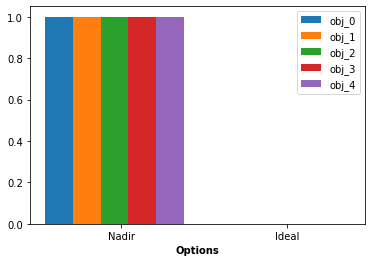

In [6]:
display_options(np.array([nadir, ideal]), names=["Nadir", "Ideal"])

Run the first iteration which returns the first intermediate points and the corresponding lower bounds of the reachable objective vectors from each of these intermediate points. The lower values are shown as stacked histograms, with the black region showing a lowest reachable value for each objective function from each point.

Dropdown(options=(1, 2, 3, 4, 5), value=1)

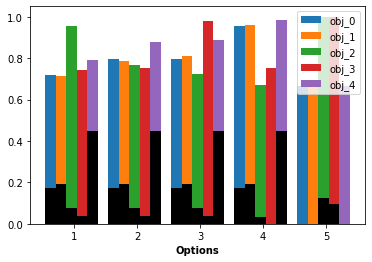

In [7]:
zs, lows = enautilus.iterate()
display_options(zs, lows=lows)
s = z_selector(zs)
display(s)

We can specify our preferred point to the algorithm in the interaction phase from which the next intermediate points are to be generated. You can use the drop down menu above the bar graph to select a preferred point.

In [8]:
# s.value is just the value selected in the dropdown menu. Substract one from it for indexing to work.
left = enautilus.interact(zs[s.value-1], lows[s.value-1])
print("Iterations left:", left)

Iterations left: 2


Iterate again from the new selected point.

Dropdown(options=(1, 2, 3, 4, 5), value=1)

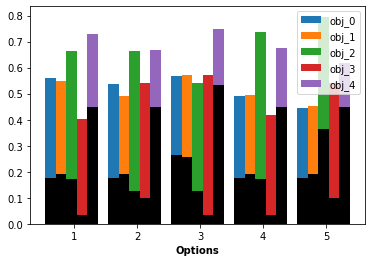

In [9]:
zs, lows = enautilus.iterate()
display_options(zs, lows=lows)
s = z_selector(zs)
display(s)

In [10]:
left = enautilus.interact(zs[s.value-1], lows[s.value-1])
print("Iterations left:", left)

Iterations left: 1


Dropdown(options=(1, 2, 3, 4, 5), value=1)

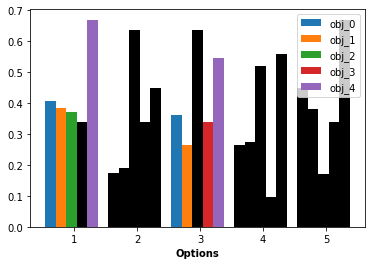

In [11]:
zs, lows = enautilus.iterate()
display_options(zs, lows=lows)
s = z_selector(zs)
display(s)

## Final solution
For the last iteration, observe that each of the graphs is black, meaning we have reached points where we can no more imporove any of the objective values. In other words, we have reached a set non-dominated solutions.

We call interact for the last time, and this time, it will yield the point selected in the last iteration. The objective values are scaled back to the original values.

(Later on, the option to project this last point to the Pareto front for example by minimizing an ASF with the last selected point being a reference point, will be added.)

In [12]:
x, f = enautilus.interact(zs[s.value-1], lows[s.value-1])
print("Final solution:", x)
print("With final objective values:", scaler.inverse_transform(f.reshape(1, -1)))

Final solution: [-0.83136724  4.79000077  7.57301133  7.67941682  6.62483849  7.53972491
  7.1287535   6.28189637  5.41238472  6.75001618  5.18173237 -0.98943435
 27.7436825   5.34605945]
With final objective values: [[ 2.06798720e+05  3.20896240e+04 -8.22875854e-01 -9.36685941e-01
  -8.91734514e+00]]
